# Assignment 2B: Evalution

This notebook contains the skeleton for evaluating a document ranking against the ground truth.

## Loading ranking file and relevance judgments

The file format is [specified in the assignment](https://github.com/kbalog/uis-dat640-fall2019/tree/master/assignments/assignment-2b#output-file-format).

In [31]:
import pandas as pd
import math
from glob import glob
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

qrels = pd.read_csv('data/qrels.csv', index_col='QueryId')
base_ranking = pd.read_csv('data/ranking_bm25.csv', index_col='QueryId')
cross_ranking = pd.read_csv('data/cross_validation.csv', index_col='QueryId')

## Computing NDCG scores

In [12]:
def dcg(gains, k):
    dcg = gains[0]
    for i in range(1, min(k, len(gains))): 
        dcg += gains[i] / math.log2(i+1)
    return dcg

# note : k has to be less than the number of documents ranked
def ndcg_score(ranking, qrels, k=20):
    sum_ndcg = 0

    for query in ranking.index.unique():
        ground_truth = qrels.loc[query]

        gains = []
        for doc_id in ranking.loc[query]['DocumentId'].values:
            gain = ground_truth[ground_truth['DocumentId'] == doc_id]['Relevance']
            gains.append(0 if gain.empty else int(gain))

        ideal_gain = sorted(ground_truth['Relevance'], reverse=True)

        ndcg = dcg(gains, k) / dcg(ideal_gain, k)
        sum_ndcg += ndcg
    
    average_ndcg = sum_ndcg/ranking.index.nunique()
    return average_ndcg

We compute NDCG scores on the generated rankings.

In [32]:
for K in [10, 20, 100]:
    print(f'Average NDCG@{K} for base ranking : {ndcg_score(base_ranking, qrels, k=K):.4f}')
    print(f'Average NDCG@{K} for cross validation ranking : {ndcg_score(cross_ranking, qrels, k=K):.4f}\n')

Average NDCG@10 for base ranking : 0.1657
Average NDCG@10 for cross validation ranking : 0.1650

Average NDCG@20 for base ranking : 0.1534
Average NDCG@20 for cross validation ranking : 0.1793

Average NDCG@100 for base ranking : 0.1110
Average NDCG@100 for cross validation ranking : 0.1105



## Identifying the optimal features subset

We plot the NDCG scores of the submodels trained in the previous part.

100%|██████████| 64/64 [00:33<00:00,  1.92it/s]


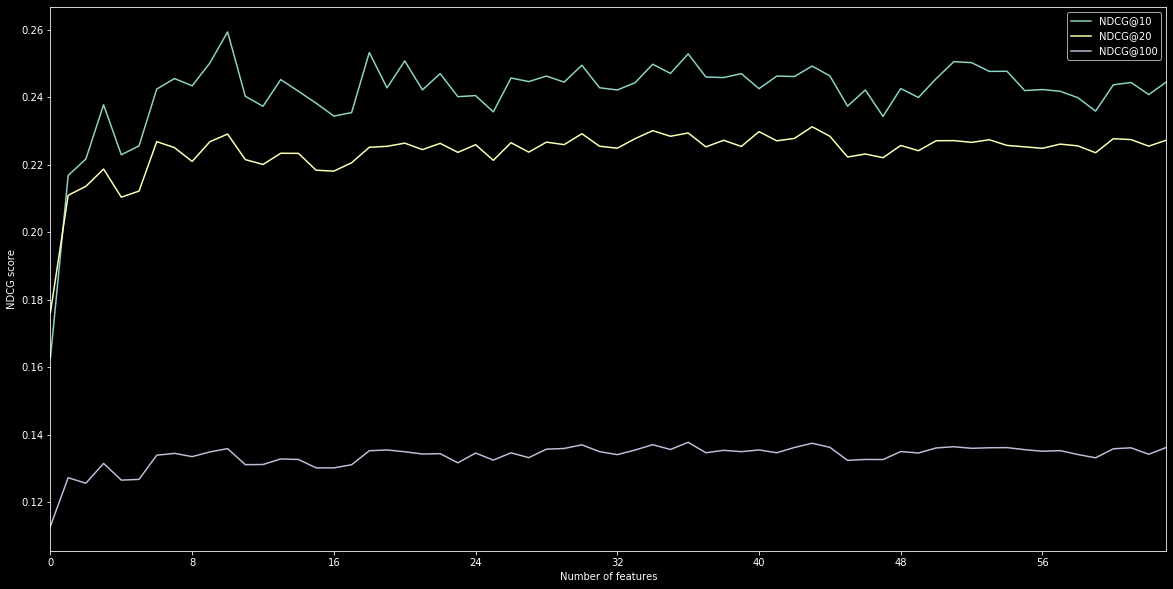

In [14]:
n_features_scores = {}

for K in [10, 20, 100]:
    n_features_scores[f'NDCG@{K}'] = []
    for subranking in tqdm(sorted(glob('data/submodel_*'))):
        ranking = pd.read_csv(subranking, index_col='QueryId')
        ndcg = ndcg_score(ranking, qrels, k=K)
        n_features_scores[f'NDCG@{K}'].append(ndcg)

n_features_scores = pd.DataFrame(n_features_scores)
ax = n_features_scores.plot(figsize=(20, 10))
ax.set_xlabel('Number of features')
ax.set_ylabel('NDCG score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))